# REINFORCE

In [4]:
""" This REINFORCE algorithm is Implemented by Yinyu Jin """
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
%matplotlib inline

# avoid the gym warning message
gym.logger.set_level(40)

env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(1)

np.random.seed(1)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()


class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size =24, learning_rate = 0.01): 
        super (PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = F.softmax(self.fc2(x), dim=1)
        return x
        
    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        act_probs = self.forward(state)
        c = Categorical(act_probs)
        action = c.sample()
        return action.item(), c.log_prob(action)
    
    def update_policy(self, vts, log_probs): 
        policy_loss = []
        for log_prob, vt in zip (log_probs, vts):
            policy_loss.append (-log_prob * vt)
            
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        
    def discounted_norm_rewards (self, rewards, GAMMA):
        vt = np.zeros_like(rewards)
        running_add = 0
        for t in reversed (range(len(rewards))):
            running_add = running_add * GAMMA + rewards[t]
            vt[t] = running_add
            
        #normalized discounted rewards
        vt = (vt - np.mean(vt)) / (np.std(vt)+eps)
        return vt


policy_net = PolicyNetwork(state_space,action_space)


def main (episodes = 5000, GAMMA = 0.99):
    all_rewards = []
    running_rewards = []
    for episode in range(episodes): 
        state = env.reset()
        rewards = []
        log_probs = []

        while True:
            action, log_prob = policy_net.choose_action(state)
            new_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            if done: 
                vt = policy_net.discounted_norm_rewards(rewards, GAMMA)
                policy_net.update_policy(vt, log_probs)
                all_rewards.append(np.sum(rewards))
                running_rewards.append(np.mean(all_rewards[-30:]))
                if episode % 100 ==0:
                    print('episode:', episode, 'total reward: ', all_rewards[-1], 'running reward:', int(running_rewards[-1]))
                break
            state = new_state
                
    return all_rewards, running_rewards, vt

all_rewards, running_rewards, vt = main()

episode: 0 total reward:  -17695.0 running reward: -17695
episode: 100 total reward:  -4781.0 running reward: -11849
episode: 200 total reward:  -976.0 running reward: -2335
episode: 300 total reward:  -1474.0 running reward: -1226
episode: 400 total reward:  -2211.0 running reward: -1409
episode: 500 total reward:  -1603.0 running reward: -2610
episode: 600 total reward:  -762.0 running reward: -598
episode: 700 total reward:  -453.0 running reward: -469
episode: 800 total reward:  -373.0 running reward: -496
episode: 900 total reward:  -581.0 running reward: -406
episode: 1000 total reward:  -431.0 running reward: -394
episode: 1100 total reward:  -237.0 running reward: -438
episode: 1200 total reward:  -357.0 running reward: -305
episode: 1300 total reward:  -363.0 running reward: -394
episode: 1400 total reward:  -231.0 running reward: -273
episode: 1500 total reward:  -136.0 running reward: -250
episode: 1600 total reward:  -140.0 running reward: -235
episode: 1700 total reward:  

### Plot the total rewards for all episodes

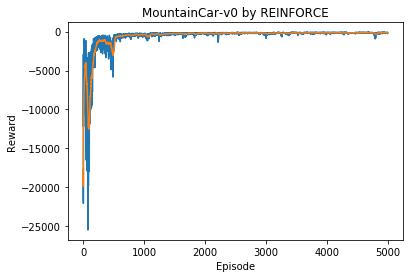

In [5]:
plt.plot(all_rewards)       
plt.plot(running_rewards)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig(f"15.9.jpg", dpi=600)
plt.show()

### Plot the $v_t$ in the last episode. 

$v_t$ here refers to the __normalised discounted returns__ received by the agent after taking action $a$ in state $s$ in an episode, which is used to evaluate the intensity of inducing the gradient. 

We can see that the values at the last steps are much higher than it was at the beginning, which means that it affects the $policy\_loss.append (-log\_prob * vt)$ a lot at the last steps. This makes sense that we should emphasize the steps that the car drives up to the mountain, since we always get the -1 reward except for the car reaches the top. 

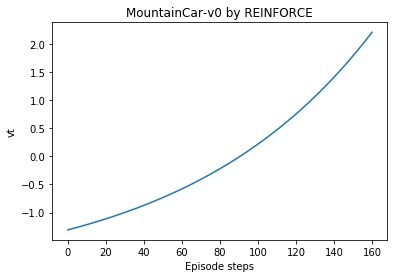

In [22]:
plt.plot(vt)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode steps')
plt.ylabel('vt')
plt.savefig(f"15.10.jpg", dpi=600)
plt.show()

### Run your well-trained REINFORCE agent!

In [23]:
env = gym.make('MountainCar-v0')

state = env.reset()
for t in range(10000):
    action, _ = policy_net.choose_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()